In [ ]:
# Section 8 Réseaux de Neurones Récurrents - RNNs Part 2 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

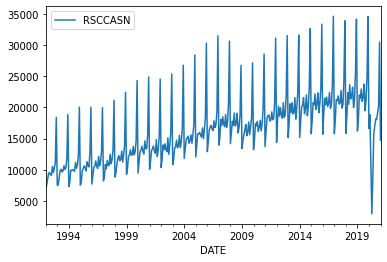

In [4]:
df.plot ()

In [6]:
df.columns = ['Sales']
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2020-09-01,18031
2020-10-01,19187
2020-11-01,20228


In [21]:
#cycle annuel

print (len (df) - 14)



335


In [25]:
#set de test et de train 

test_ind  = len (df) - 18

train = df.iloc [ :  test_ind ]

test = df.iloc [ test_ind : ]

In [26]:
# normaliser 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler ()

scaler.fit (train)

train_scaled = scaler.transform (train)
test_scaled  = scaler.transform (test)

In [27]:
# generator 

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [28]:
len (test)

18

In [29]:
# definir un batch 
# il doit etre inferieur a len de test (18)

length = 12 #la longueur du batch est de 12 mois car c est une année
batch_size = 1   #1 batch a la fois 


generator = TimeseriesGenerator (   train_scaled,
    train_scaled,
    length = length,
    batch_size=batch_size  )   

In [30]:
#check du 1er batch 

X,y = generator [0]

In [38]:
scaler.inverse_transform(X.reshape  (12, 1))
# X.reshape  (12, 1)

array([[ 6938.],
       [ 7524.],
       [ 8475.],
       [ 9401.],
       [ 9558.],
       [ 9182.],
       [ 9103.],
       [10513.],
       [ 9573.],
       [10254.],
       [11187.],
       [18395.]])

In [40]:
train [:12]

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
1992-06-01,9182
1992-07-01,9103
1992-08-01,10513
1992-09-01,9573


In [50]:
int(scaler.inverse_transform(y))

7502

In [51]:
train.iloc[12] ['Sales']

7502

In [71]:
#RNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM , SimpleRNN

model = Sequential ()

n_features = 1   # 1 seul feature

model= Sequential ()

model.add ( LSTM ( 100 , 
                  input_shape = ( length , n_features ) , 
                  activation = 'relu') )

model.add ( Dense ( 1 ) )

model.compile (optimizer = 'adam', loss = 'mse')

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [72]:
# callbacks 
from tensorflow.keras.callbacks import EarlyStopping 
ea = EarlyStopping (    monitor='val_loss',
    patience=2)

In [73]:
#donnée de validation
validation_generator = TimeseriesGenerator (   test_scaled,
    test_scaled,
    length = length,
    batch_size=batch_size  )   

In [74]:
#fit 

model.fit (  generator , 
    epochs=20,
    callbacks=[ea],
    validation_data=validation_generator,)

Epoch 1/20
319/319 [==============================] - 3s 9ms/step - loss: 0.0236 - val_loss: 0.0360
Epoch 2/20
319/319 [==============================] - 2s 7ms/step - loss: 0.0192 - val_loss: 0.0468
Epoch 3/20
319/319 [==============================] - 3s 9ms/step - loss: 0.0155 - val_loss: 0.0138
Epoch 4/20
319/319 [==============================] - 3s 9ms/step - loss: 0.0061 - val_loss: 0.0118
Epoch 5/20
319/319 [==============================] - 3s 9ms/step - loss: 0.0032 - val_loss: 0.0202
Epoch 6/20
319/319 [==============================] - 3s 9ms/step - loss: 0.0019 - val_loss: 0.0178


<AxesSubplot:>

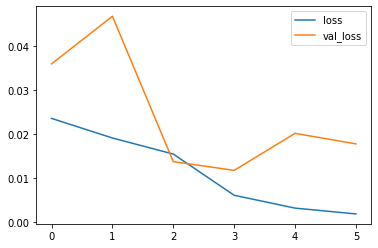

In [75]:
pd.DataFrame(model.history.history).plot()

In [ ]:
# prediction et verification sur le set de test

In [76]:
test_prediction = []   #liste vide
first_eval_batch = train_scaled[-length :]   # le dernier batch du set de train
current_batch = first_eval_batch.reshape (1,length,n_features) #reshape


for i in range (len (test)) : 
    
    # 1 - prediction sur le batch
    current_pred = model.predict ( current_batch ) [0]
    
    # 2 - ajout de la prediction dans le batch pour les prochaines predictions
    # la dim de la prediction peut etre a modifier 
    current_batch = np.append (  current_batch [ : , 1: , : ] , [[current_pred] ], axis = 1 )
    
    # 3 - ajout de la prediciton dans la liste
    test_prediction.append (current_pred  )
    

In [78]:
scaler.inverse_transform (test_prediction)

array([[22803.85139799],
       [20062.01148379],
       [21388.60770708],
       [25599.42839628],
       [36072.5418036 ],
       [15994.89572248],
       [17841.66573218],
       [21337.98311502],
       [20985.01629287],
       [22443.85796428],
       [20720.41818309],
       [21423.94859427],
       [22482.43010312],
       [20234.80427435],
       [21530.1081593 ],
       [25698.81536341],
       [39253.6702981 ],
       [15598.47359633]])

In [87]:
test ['pred'] = scaler.inverse_transform (test_prediction) 

<ipython-input-87-b347f282a140>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test ['pred'] = scaler.inverse_transform (test_prediction)


<AxesSubplot:xlabel='DATE'>

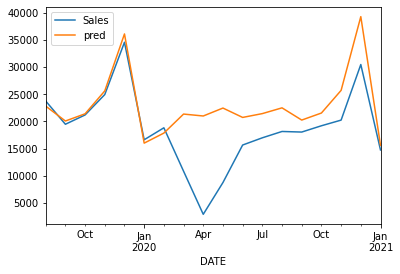

In [89]:
test.plot()

In [ ]:
#predire le futur 

In [90]:
# normaliser le df

full_scaler = MinMaxScaler ()
df_scaled = full_scaler.fit_transform ( df )

In [92]:
# generator

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 12 
batch_size = 1

full_generator = TimeseriesGenerator ( df_scaled,
    df_scaled,
    length = length,
    batch_size=batch_size,)

In [94]:
# RNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM 

n_features = 1

model= Sequential ()

model.add ( LSTM ( 200 , 
                  input_shape = ( length , n_features ) ,
                  activation = 'relu'
                 ) )
model.add ( Dense ( 1 ) )

model.compile (optimizer = 'adam', loss = 'mse')

In [95]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [99]:
model.fit (  generator ,
    epochs=15,
          )

Epoch 1/15
319/319 [==============================] - 3s 10ms/step - loss: 0.0241
Epoch 2/15
319/319 [==============================] - 3s 8ms/step - loss: 0.0205
Epoch 3/15
319/319 [==============================] - 2s 8ms/step - loss: 0.0202
Epoch 4/15
319/319 [==============================] - 3s 8ms/step - loss: 0.0197
Epoch 5/15
319/319 [==============================] - 3s 8ms/step - loss: 0.0195
Epoch 6/15
319/319 [==============================] - 3s 8ms/step - loss: 0.0186
Epoch 7/15
319/319 [==============================] - 2s 8ms/step - loss: 0.0175
Epoch 8/15
319/319 [==============================] - 3s 8ms/step - loss: 0.0159
Epoch 9/15
319/319 [==============================] - 3s 8ms/step - loss: 0.0148
Epoch 10/15
319/319 [==============================] - 3s 8ms/step - loss: 0.0139
Epoch 11/15
319/319 [==============================] - 2s 8ms/step - loss: 0.0122
Epoch 12/15
319/319 [==============================] - 3s 8ms/step - loss: 0.0104
Epoch 13/15
319/319 [===

<AxesSubplot:>

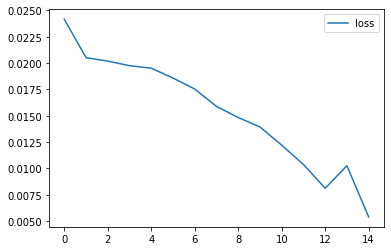

In [102]:
pd.DataFrame(model.history.history).plot()

In [103]:
forecast = []   #liste vide
first_eval_batch = train_scaled[-length :]   # le dernier batch du set de train
current_batch = first_eval_batch.reshape (1,length,n_features) #reshape

periods = 12

for i in range (periods) : 
    
    # 1 - prediction sur le batch
    current_pred = model.predict ( current_batch ) [0]
    
    # 2 - ajout de la prediction dans le batch pour les prochaines predictions
    # la dim de la prediction peut etre a modifier 
    current_batch = np.append (  current_batch [ : , 1: , : ] , [[current_pred] ], axis = 1 )
    
    # 3 - ajout de la prediciton dans la liste
    forecast.append (current_pred  )

In [105]:
full_fore = full_scaler.inverse_transform (  forecast )
full_fore

array([[20652.07138538],
       [18680.59682107],
       [20980.66937828],
       [24881.83127135],
       [28523.33815706],
       [15087.93021977],
       [17274.46040779],
       [20485.98644811],
       [20495.02765542],
       [21189.7718659 ],
       [19766.70586753],
       [20198.56147832]])

In [110]:
len (full_fore)

12

In [111]:
#ajout d un index de temps 

df.index 

DatetimeIndex(['2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [112]:
date_index = pd.date_range ( start= '2021-02-01',
    periods= 12 , 
    freq='MS'   )

In [116]:
fore = pd.DataFrame ( full_fore , 
                     index =  date_index , 
                     columns = ['predict'])

fore

,predict
2021-02-01,20652.071385
2021-03-01,18680.596821
2021-04-01,20980.669378
2021-05-01,24881.831271
2021-06-01,28523.338157
2021-07-01,15087.930220
2021-08-01,17274.460408
2021-09-01,20485.986448
2021-10-01,20495.027655
2021-11-01,21189.771866


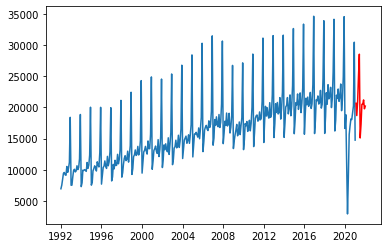

In [120]:
# fore.plot()

plt.plot ( df)
plt.plot ( fore , 'r')
